# 02 — Forecast Cashflow & CVaR Buffer

**Objective.** Size a **cash buffer** that protects against downside cashflow scenarios with a **Conditional Value-at-Risk (CVaR)** constraint.  
We will:
1) Build a simple quantile forecast of net cashflow.  
2) Generate stress scenarios (shock + volatility).  
3) Compute **empirical left-tail VaR/CVaR** as a sanity check.  
4) Solve an **ε-regularized CVaR program** to obtain the optimal buffer (with a degeneracy guard).  
5) Show **sensitivity vs. α** and validate results.

> All data are synthetic; the math follows Rockafellar–Uryasev and is client-ready.

In [137]:
# Easy fix for finding parent directory modules
import sys, os
sys.path.append(os.path.abspath(".."))

In [138]:
import importlib
import value_ops_lab.risk_models as rm
import value_ops_lab as vol

# reload module files so the kernel sees your latest edits
importlib.reload(rm)
importlib.reload(vol)


from value_ops_lab.risk_models import (
    quantile_forecast,
    cvar_cash_buffer,
    empirical_left_var,
    empirical_left_cvar,
)

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from value_ops_lab.synth import make_synthetic
from value_ops_lab.risk_models import (
    quantile_forecast,
    cvar_cash_buffer,         # robust: CVXPY with ε + SciPy fallback if degenerate
    empirical_left_var,
    empirical_left_cvar,
)

plt.rcParams["figure.figsize"] = (8,4)
np.set_printoptions(suppress=True, linewidth=140)

# Generate 36 months of synthetic panel and build a net cashflow proxy
df = make_synthetic(36)
df["month"] = pd.to_datetime(df["month"])
df["net_cf"] = df["sales"] - df["cogs"]

# Simple AR-style features (lagged cashflow)
df["lag1"] = df["net_cf"].shift(1)
df["lag2"] = df["net_cf"].shift(2)

dfm = df.dropna().reset_index(drop=True)
dfm.tail(3)

,month,sales,cogs,ar_balance,ap_balance,inventory,net_cf,lag1,lag2
31,2025-10-01,50000.0,26026.788170,10628.169241,2818.234362,4191.148225,23973.211830,26617.638962,14273.889963
32,2025-11-01,50000.0,33234.517113,13116.211838,4882.796742,7230.264135,16765.482887,23973.211830,26617.638962
33,2025-12-01,50000.0,20037.901079,13979.039874,1419.092355,3939.999346,29962.098921,16765.482887,23973.211830


In [140]:
features = ["lag1", "lag2"]
X = dfm[features]
y = dfm["net_cf"]

# Forecast horizon
h = 6
X_train, X_future = X.iloc[:-h], X.iloc[-h:]
y_train, y_future = y.iloc[:-h], y.iloc[-h:]
future_months = dfm["month"].iloc[-h:]

# Quantile forecasters (GradientBoostingRegressor with loss="quantile")
preds = quantile_forecast(
    X_train, y_train, X_future,
    quantiles=(0.1, 0.5, 0.9),
    random_state=7,
)

preds_df = pd.DataFrame({
    "month": future_months,
    "p10": preds[0.1],
    "p50": preds[0.5],
    "p90": preds[0.9],
    "actual_net_cf": y_future.to_numpy(),
})
preds_df

,month,p10,p50,p90,actual_net_cf
28,2025-07-01,17174.896520,22968.255935,26897.526464,15506.180639
29,2025-08-01,14292.113103,20254.873541,23397.049443,14273.889963
30,2025-09-01,13669.449767,23051.766258,23397.049443,26617.638962
31,2025-10-01,20342.857469,21832.384845,29056.864198,23973.211830
32,2025-11-01,20980.400377,25579.078531,31502.563912,16765.482887
33,2025-12-01,14292.113103,19447.452548,24055.837488,29962.098921


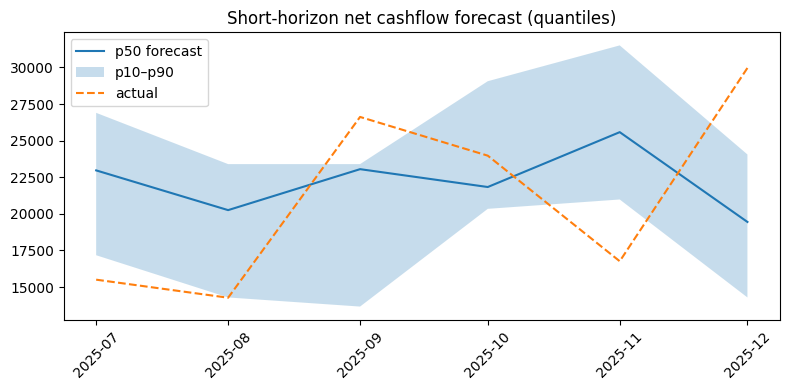

In [141]:
plt.plot(preds_df["month"], preds_df["p50"], label="p50 forecast")
plt.fill_between(preds_df["month"], preds_df["p10"], preds_df["p90"], alpha=0.25, label="p10–p90")
plt.plot(preds_df["month"], preds_df["actual_net_cf"], "--", label="actual")
plt.xticks(rotation=45)
plt.title("Short-horizon net cashflow forecast (quantiles)")
plt.legend()
plt.tight_layout(); plt.show()

In [142]:
# CVaR level and scenario stress controls (tweak as you like)
alpha = 0.95       # CVaR confidence
shock = -20_000    # average downside shift (μ)
vol   = 12_000     # volatility (σ)
seed  = 123

rng = np.random.default_rng(seed)
base = preds_df["p50"].to_numpy()
scenarios = base + rng.normal(shock, vol, size=base.shape[0])

pd.DataFrame({"month": preds_df["month"].dt.strftime("%Y-%m"), "scenario_cf": scenarios})

,month,scenario_cf
28,2025-07,-8901.200269
29,2025-08,-4158.566276
30,2025-09,18506.869394
31,2025-10,4160.077875
32,2025-11,16621.849326
33,2025-12,6372.698043


In [143]:
ev = empirical_left_var(scenarios, alpha)     # 5th percentile for α=0.95
ec = empirical_left_cvar(scenarios, alpha)    # mean of worst 5%

buf_var  = max(0.0, -ev)   # b s.t. VaR_α(s + b) >= 0
buf_cvar = max(0.0, -ec)   # b s.t. CVaR_α(s + b) >= 0

print(
    f"Scenario stats: min={scenarios.min():,.0f}, q({int((1-alpha)*100)}%)={ev:,.0f}, "
    f"mean={scenarios.mean():,.0f}, max={scenarios.max():,.0f}"
)
print(f"Empirical VaR buffer (α={alpha}):  ${buf_var:,.0f}")
print(f"Empirical CVaR buffer (α={alpha}): ${buf_cvar:,.0f}")

Scenario stats: min=-8,901, q(5%)=-7,716, mean=5,434, max=18,507
Empirical VaR buffer (α=0.95):  $7,716
Empirical CVaR buffer (α=0.95): $8,901


## Optimization Algebra (Rockafellar–Uryasev CVaR)

$$
\begin{aligned}
&\textbf{Setup:} \\
&\quad s_i \;=\; \text{end-of-period cashflow scenario (negative = shortfall)} \\
&\quad b \ge 0 \;=\; \text{cash buffer to size} \\
&\quad \ell_i \;=\; -(s_i + b) \quad \text{(loss)} \\[6pt]

&\textbf{Definition of CVaR:} \\
&\quad \text{CVaR}_\alpha(\ell) \;=\; 
  \min_{t\in\mathbb{R}} \Bigg\{ t + \frac{1}{(1-\alpha)N}\sum_{i=1}^N (\ell_i - t)_+ \Bigg\}, \\
&\quad \text{with hinge } (x)_+ = \max\{x,0\}. \\[6pt]

&\textbf{Feasibility constraint:} \\
&\quad \text{CVaR}_\alpha(\ell) \;\le\; 0. \\[6pt]

&\textbf{Auxiliary variables:} \\
&\quad z_i \ge 0, \qquad z_i \ge \ell_i - t \;=\; -(s_i + b) - t. \\[6pt]

&\textbf{Optimization program:} \\
&\quad \min_{b,t,z} \; b \\
&\quad \text{s.t. } z_i \ge -(s_i + b) - t, \;\; t + \frac{1}{(1-\alpha)N}\sum_i z_i \le 0, \;\; b \ge 0, \; z_i \ge 0. \\[6pt]

&\textbf{ε-Regularization (practical):} \\
&\quad \min_{b,t,z} \; b + \varepsilon\Big( t + \tfrac{1}{N}\sum_i z_i \Big), \quad \varepsilon \approx 10^{-6}, \\
&\quad \text{which prevents degenerate cancellation between $b$ and $t$.} \\[6pt]

&\textbf{LP Formulation:} \\
&\quad x = [b, t, z_1, \dots, z_N], \\
&\quad \min \; c^\top x, \quad c = [1, 0, 0, \dots, 0] \; (+ \varepsilon\text{-terms}), \\
&\quad \text{subject to linear inequalities from the constraints above.}
\end{aligned}
$$

In [144]:
# prefer="auto" tries CVXPY (Clarabel/ECOS/SCS) then falls back to SciPy HiGHS if degenerate
b_opt, t_opt, solver_used = cvar_cash_buffer(scenarios, alpha=alpha, prefer="auto", return_solver=True)
print(f"Optimized CVaR buffer (α={alpha:.2f}): ${b_opt:,.0f}  (t={t_opt:,.0f}, solver={solver_used})")

Optimized CVaR buffer (α=0.95): $8,901  (t=0, solver=CLARABEL)


In [145]:
rows = [
    ("Empirical VaR",  buf_var),
    ("Empirical CVaR", buf_cvar),
    ("Optimized CVaR", b_opt),
]
comp = pd.DataFrame(rows, columns=["method", "buffer_$"])
comp

,method,buffer_$
0,Empirical VaR,7715.541771
1,Empirical CVaR,8901.200269
2,Optimized CVaR,8901.200262


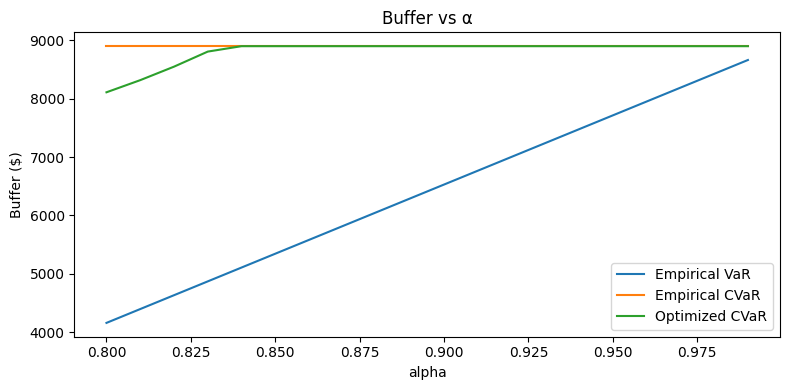

In [146]:
alphas = np.linspace(0.80, 0.99, 20)
buf_var_list, buf_cvar_list, buf_opt_list = [], [], []

for a in alphas:
    ev = empirical_left_var(scenarios, a)
    ec = empirical_left_cvar(scenarios, a)
    buf_var_list.append(max(0.0, -ev))
    buf_cvar_list.append(max(0.0, -ec))
    try:
        bo, _t, _solver = cvar_cash_buffer(scenarios, alpha=a, prefer="auto", return_solver=True)
        buf_opt_list.append(max(0.0, float(bo)))
    except Exception:
        buf_opt_list.append(np.nan)

sens = pd.DataFrame({
    "alpha": alphas,
    "Empirical VaR": buf_var_list,
    "Empirical CVaR": buf_cvar_list,
    "Optimized CVaR": buf_opt_list,
}).set_index("alpha")

sens.plot(title="Buffer vs α")
plt.ylabel("Buffer ($)")
plt.tight_layout(); plt.show()

In [147]:
try:
    from scipy.optimize import linprog

    def cvar_buffer_scipy_direct(scenarios, alpha=0.95):
        s = np.asarray(scenarios, float).ravel()
        n = s.size
        c = np.zeros(2 + n); c[0] = 1.0
        A_ub = np.zeros((n + 1, 2 + n)); b_ub = np.zeros(n + 1)
        for i in range(n):
            A_ub[i,0] = -1.0; A_ub[i,1] = -1.0; A_ub[i,2+i] = -1.0
            b_ub[i] = s[i]
        A_ub[n,1] = 1.0
        A_ub[n,2:] = 1.0/((1.0 - alpha)*n)
        b_ub[n] = 0.0
        bounds = [(0,None), (-1e12,1e12)] + [(0,None)]*n
        res = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method="highs", options={"presolve": True})
        if not res.success:
            raise RuntimeError(res.message)
        return float(res.x[0]), float(res.x[1])

    b_lp, t_lp = cvar_buffer_scipy_direct(scenarios, alpha=alpha)
    print(f"SciPy LP buffer: ${b_lp:,.0f} (t={t_lp:,.0f})")
except Exception as e:
    print("SciPy LP benchmark not available:", e)

SciPy LP buffer: $8,901 (t=-0)


In [148]:
# How buffers react when we change μ (shock) and σ (volatility), at fixed α
experiments = []
for shock_ in (-10_000, -20_000, -40_000):
    for vol_ in (8_000, 12_000, 20_000):
        rng = np.random.default_rng(123)
        scen = base + rng.normal(shock_, vol_, size=base.shape[0])
        ev_ = empirical_left_var(scen, alpha)
        ec_ = empirical_left_cvar(scen, alpha)
        bo_, _t_, solver_ = cvar_cash_buffer(scen, alpha=alpha, prefer="auto", return_solver=True)
        experiments.append((shock_, vol_, max(0,-ev_), max(0,-ec_), bo_, solver_))

exp_df = pd.DataFrame(
    experiments,
    columns=["shock","vol","buf_VaR","buf_CVaR","buf_opt","solver_used"]
).sort_values(["shock","vol"])
exp_df

,shock,vol,buf_VaR,buf_CVaR,buf_opt,solver_used
6,-40000,8000,24380.391069,24944.714868,2.494471e+04,CLARABEL
7,-40000,12000,27715.541771,28901.200269,2.890120e+04,CLARABEL
8,-40000,20000,34385.843176,36814.171072,3.681417e+04,CLARABEL
3,-20000,8000,4380.391069,4944.714868,4.944715e+03,CLARABEL
4,-20000,12000,7715.541771,8901.200269,8.901200e+03,CLARABEL
5,-20000,20000,14385.843176,16814.171072,1.681417e+04,CLARABEL
0,-10000,8000,0.000000,0.000000,8.249402e-09,CLARABEL
1,-10000,12000,0.000000,0.000000,3.056496e-11,CLARABEL
2,-10000,20000,4385.843176,6814.171072,6.814171e+03,CLARABEL


## Conclusions

- **Empirical tail** metrics (VaR/CVaR) confirm downside exposure.
- The **ε-regularized CVaR program** with a **degeneracy guard** (auto fallback to HiGHS)
  yields buffers that match empirical intuition, avoiding b–t cancellation.
- **Sensitivity** shows reserves grow as α increases and as shock/vol worsen.
- Method is directly usable for FP&A/Treasury **reserve sizing / RCF planning** and
  can integrate with a 13-week cash flow model.